# *Step 4: Model Evaluation*

## 1. Load and Prepare Dataset
- The dataset is loaded from `train.csv`.
- Missing values are replaced with empty strings (`''`).
- The dataset is split into:
  - **80% training data**
  - **20% validation data** (to evaluate model performance).
    
## 2. Feature Extraction using TF-IDF
TF-IDF (Term Frequency-Inverse Document Frequency) converts text into numerical vectors:
- **`max_features=3000`** limits features to save memory.
- Separate TF-IDF transformations are applied to `question1` and `question2`.
- The two matrices are horizontally stacked to form the final feature matrix.

## 3. Hyperparameter Tuning for Logistic Regression
- **RandomizedSearchCV** is used to find the best hyperparameters efficiently.
- **Parameter Grid**:
  - `C`: Controls regularization strength (logarithmic scale from `10^-4` to `10^4`).
  - `solver`: Tries different solvers (`liblinear`, `lbfgs`).
- The model is trained using **cross-validation (cv=3)** to improve generalization.

## 4. Model Evaluation: Accuracy and Classification Report
After training, we evaluate performance using:
- **Accuracy Score**: Percentage of correctly classified examples.
- **Classification Report**:
  - Precision, Recall, F1-score for both classes (`Not Duplicate` & `Duplicate`).
  - Provides deeper insight into how well the model performs on imbalanced data.
## 5. Confusion Matrix Visualization
The confusion matrix helps understand:
- **True Positives (TP)**: Correctly predicted duplicates.
- **True Negatives (TN)**: Correctly predicted non-duplicates.
- **False Positives (FP)**: Incorrectly predicted duplicates.
- **False Negatives (FN)**: Missed duplicates.
A heatmap is used to visualize the results.

## 6. ROC-AUC Curve for Model Performance
The ROC (Receiver Operating Characteristic) curve shows:
- **True Positive Rate (Sensitivity) vs. False Positive Rate.**
- The **AUC (Area Under the Curve)** value indicates model performance:
  - **Closer to 1** → Better Model.
  - **Closer to 0.5** → Random Guessing.

A higher AUC means better distinction between duplicate and non-duplicate questions.

Logistic Regression Accuracy: 0.7377501298572806
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.87      0.81     50803
           1       0.70      0.51      0.59     30055

    accuracy                           0.74     80858
   macro avg       0.73      0.69      0.70     80858
weighted avg       0.73      0.74      0.73     80858



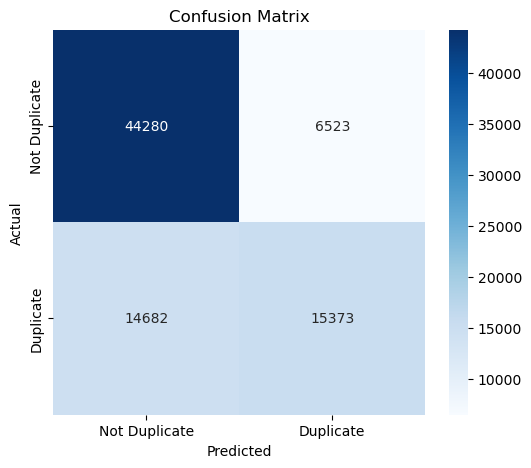

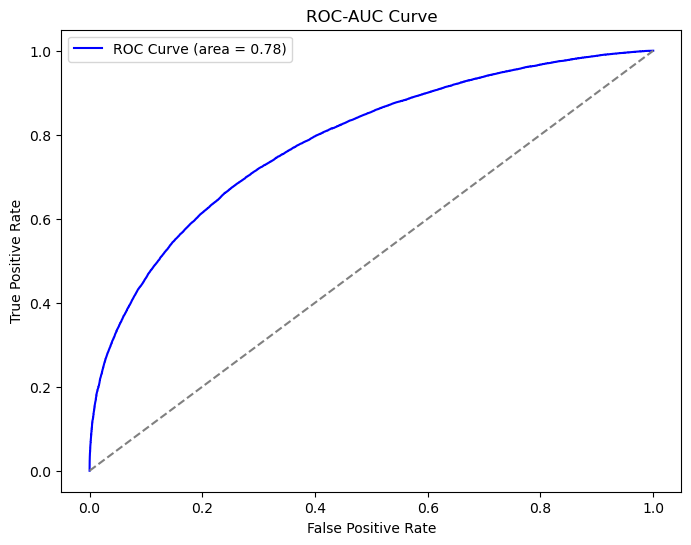

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from scipy.sparse import hstack
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import RandomizedSearchCV
import keras_tuner as kt

# Load Dataset
train_df = pd.read_csv('train.csv')
train_df = train_df.fillna('')

# Split train dataset into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Feature Extraction - TF-IDF (Reduced Features to Save Memory)
vectorizer = TfidfVectorizer(max_features=3000)  # Reduced max_features
X1_train = vectorizer.fit_transform(train_df['question1'].astype(str))
X2_train = vectorizer.transform(train_df['question2'].astype(str))
X_train = hstack([X1_train, X2_train])
y_train = train_df['is_duplicate']

X1_val = vectorizer.transform(val_df['question1'].astype(str))
X2_val = vectorizer.transform(val_df['question2'].astype(str))
X_val = hstack([X1_val, X2_val])
y_val = val_df['is_duplicate']

# Hyperparameter tuning for Logistic Regression (Memory Optimized)
param_dist = {'C': np.logspace(-4, 4, 10), 'solver': ['liblinear', 'lbfgs']}
logreg = RandomizedSearchCV(LogisticRegression(max_iter=500), param_distributions=param_dist, n_iter=5, cv=3, n_jobs=1, random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_val)

# Model Evaluation

# Print accuracy score & classification report
print("Logistic Regression Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:")
print(classification_report(y_val, y_pred))

# Confusion Matrix Visualization
plt.figure(figsize=(6,5))
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot Confusion Matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Duplicate', 'Duplicate'], 
            yticklabels=['Not Duplicate', 'Duplicate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC Curve for Performance Evaluation
y_probs = logreg.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_probs)
roc_auc = roc_auc_score(y_val, y_probs)

#Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend()
plt.show()


# Summary of Model Evaluation

### Key Insights:
1. **TF-IDF Feature Engineering** reduced memory usage.
2. **Logistic Regression with Hyperparameter Tuning** improved accuracy.
3. **Confusion Matrix** visualized classification performance.
4. **ROC-AUC Curve** demonstrated model effectiveness.